In [2]:
import torch
import sam2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor as SAM

import cv2
import numpy as np
from PIL import  Image
import scipy
import skimage

import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import  partial
from queue import PriorityQueue, Queue


# Inference preparation

In [3]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

In [5]:
def get_bbox(bound, pt, patch_size):
    x = min(bound[1] - patch_size[1], max(0, pt[1] - patch_size[1] // 2))
    y = min(bound[0] - patch_size[0], max(0, pt[0] - patch_size[0] // 2))
    return x, y, patch_size[0], patch_size[1]

In [6]:
def valid_pts(pts, bbox):
    if isinstance(pts, list):
        pts = np.array(pts)
    if pts.shape[0] == 0:
        return pts
        
    pts -= bbox[:2][::-1]
    check = np.ones(pts.shape[0])
    for i in range(pts.shape[1]):
        check *= np.where((pts[:, i] > 0) & (pts[:, i] < bbox[i + 2]), 1, 0)
    return pts[np.where(check > 0)]

In [7]:
def compose_prompts(positive, negative):
    pos_label = np.ones(positive.shape[0])
    neg_label = np.zeros(negative.shape[0])
    if negative.shape[0] == 0:
        return positive[:, ::-1].copy(), pos_label
    pts = np.concatenate([positive, negative], axis=0)
    labels = np.concatenate((pos_label, neg_label))
    return pts[:, ::-1].copy(), labels

In [8]:
# A wrapper for Sam inference
class SamInferer:
    def __init__(self, cfg = "", 
                    ckpt: str = "", 
                    patch_size = [512, 512], 
                    alpha=0.1, 
                    beta=0.5, 
                    post_act=True, 
                    min_length=5,
                    kernel_size=3,
                    fill_kernel_size=7,
                    neg_dis=15,
                    sampling_grid=8,
                    thresh=0.75):
        self.predictor = SAM(build_sam2(cfg, ckpt))
        # Guidance and queries
        self.pos = np.zeros([0, 2], dtype=int)
        self.queue = PriorityQueue()

        # Negative sampling
        self.neg = np.zeros([0, 2], dtype=int)
        self.neg_dis = neg_dis
        self.sampling_grid = sampling_grid
        # We gonna prioritize long flow over short ones
        self.root = None

        # Context related
        self.a_mask = None
        self.b_mask = None
        self.image = None 
        self.alpha = alpha
        self.beta = beta
        self.post_act = post_act
        self.weight = None
        self.logits = None # Post-sigmoid or pre-sigmoid dependent
        
        # kernel configuration
        self.patch_size = np.array(patch_size)
        self.w_kernel = [cv2.getGaussianKernel(patch_size[0], patch_size[0] // 2), cv2.getGaussianKernel(patch_size[1], patch_size[1] // 2)]
        self.w_kernel = (self.w_kernel[0] / self.w_kernel[0][0, 0]) * (self.w_kernel[1] / self.w_kernel[1][0, 0]).T
        self.w_kernel /= self.w_kernel.sum() 
        # TO prevent vanishing
        self.w_kernel /= self.w_kernel.min()
        # Uncertainty modelling
        
        kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        fill_kernel_size = (fill_kernel_size, fill_kernel_size) if isinstance(fill_kernel_size, int) else fill_kernel_size
        self.close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        self.fill_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, fill_kernel_size)
        self.stable_thresh = thresh
        
        # Flow skeleton
        self.graph = defaultdict(list)
        self.min_length = min_length
        self.parent = dict()

    def pop(self):
        return  self.queue.get()[1]

    def compose_prompts(self):
        def valid_pts(pts):
            pts -= self.root[None, :]
            check = np.ones(pts.shape[0])
            for i in range(pts.shape[1]):
                check *= np.where((pts[:, i] > 0) & (pts[:, i] < self.patch_size[i]), 1, 0)
            return pts[np.where(check > 0)]
        
        valid_pos = valid_pts(self.pos.copy())
        pos_label = np.ones(valid_pos.shape[0])
        if self.neg.shape[0] == 0:
            return valid_pos, pos_label
        # Generated locally so no need for projection
        valid_neg = self.neg
        neg_label = np.zeros(valid_neg.shape[0])
        # Must be in xy format
        return np.concatenate([valid_pos, valid_neg], axis=0)[:, ::-1].copy(), np.concatenate([pos_label, neg_label], axis=0)

    def read(self, image_path, channels=3):
        self.image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)[:, :, :channels]
        self.a_mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        self.b_mask = np.zeros(self.image.shape[:2], dtype=np.uint8)
        self.logits = np.zeros(self.image.shape[:2])
        self.weight = np.full(self.image.shape[:2], 1e-6)
        self.beta = np.full(self.image.shape[:2], self.beta * self.weight)
        self.output = np.zeros_like(self.a_mask)
        self.box = self.image.shape[:2]
    
    # Generate negative prior
    def negative_sampling(self, debug = False):
        # Prepare
        pts = (self.pos - self.root).round().astype(int)
        dst = self.root + self.patch_size
        a_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self.neg_dis, self.neg_dis))
        grad_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
        
        mask = self.b_mask[self.root[0]:dst[0], self.root[1]:dst[1]].copy()
        gradient = cv2.morphologyEx(cv2.dilate(mask, a_kernel, iterations=5), cv2.MORPH_GRADIENT, grad_kernel)

        for pt in pts:
            cv2.circle(gradient, pt[::-1], self.neg_dis * 3, 0, -1)

        alpha_mask = scipy.ndimage.binary_fill_holes(self.a_mask[self.root[0]: dst[0], self.root[1]:dst[1]]).astype(int).astype(np.uint8)
        alpha_mask = cv2.dilate(alpha_mask,  a_kernel, 3)

        negative_field = gradient * (1 - alpha_mask)
        # Discretize to 5 bin
        output = grid_sampling(negative_field.astype(float), grid=self.sampling_grid, alpha=0.01)

        return {'pts': output} if not debug else {'pts': output, 'field': negative_field, 'b': alpha_mask, 'a': gradient}


    def infer(self, debug=False):
        prompt = self.pop()
        self.pos = np.concatenate([self.pos, np.array(prompt)[None,:]], axis=0)
        x, y, _, _ = get_bbox(self.box, prompt, self.patch_size)
        # Change base for referencing and post-processing.
        self.root = np.array([y, x])
        dst = self.root + self.patch_size
        # Image in RGB format
        patch = self.image[self.root[0]:dst[0], self.root[1]:dst[1], ::-1].copy()
        self.predictor.set_image(patch)

        neg = self.negative_sampling(debug=debug)
        self.neg = neg['pts']
        annotation, a_label = self.compose_prompts()
        # a_mask = cv2.resize(self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]], (256, 256))
        a_mask = self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        if not self.post_act:
            a_mask = sigmoid(a_mask)
        # Quantile for recall
        # Always lower bound it for measure
        score = max(0.4, np.quantile(a_mask, 0.98))
        a_mask = np.where(a_mask > score, 1, 0).astype(np.float32)
        
        a_mask = cv2.resize(a_mask, (256, 256), cv2.INTER_LINEAR)
        print(a_mask.max())
        # Mind that mask input must halve the size, for size matching
        print(a_mask.shape, a_label.shape, annotation.shape )
        masks, scores, logits = self.predictor.predict(point_coords=annotation, 
                                                        point_labels=a_label, 
                                                        mask_input=a_mask[None, :], 
                                                        multimask_output=False)

        return {'mask': masks[0], 
                'score': scores[0], 
                'logit': cv2.resize(logits[0], self.patch_size, interpolation=cv2.INTER_LINEAR), 
                'pts': annotation, 
                'label': a_label,
                'inp_mask': self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]].copy(),
                'prompt': prompt,
                'negative': neg}
    
    # Allow pipeline injection
    def iter(self, seg_res=None, debug=False):
        if seg_res is None:
            seg_res = self.infer(debug=debug) 
            
        dst = self.root + self.patch_size

        # Updating primitives
        print(self.patch_size, seg_res['mask'].shape, seg_res['mask'].dtype)
        score = seg_res['score'] 
        assert score > self.alpha, f"Model confidence {score} is hazardous, please make prompt to escape uncertainty"
        print(f"Score {score}")
        print(f"With {seg_res['label'].sum()} positives and {seg_res['label'].shape[0] - seg_res['label'].sum()} negatives")
        prob_map = sigmoid(seg_res['logit'])
        weight = score * self.w_kernel
        # Well, there is a case where confidence score is too low, so add tolerance 
        self.beta[self.root[0]: dst[0], self.root[1]:dst[1]] += weight * score
        if self.post_act:
            self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] += prob_map * weight
        else: 
            self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] += seg_res['logit'] * weight
        self.weight[self.root[0]: dst[0], self.root[1]:dst[1]] += weight
        
        # Subtract to get gain properties
        beta = self.beta[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        prob_map = self.logits[self.root[0]: dst[0], self.root[1]:dst[1]] / self.weight[self.root[0]: dst[0], self.root[1]:dst[1]]
        prob_map = sigmoid(prob_map) if not self.post_act else prob_map
        prob_map = prob_map ** 2
        
        self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]] = cv2.bitwise_or(self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]], (prob_map > beta).astype(np.uint8)) 
        possible = (prob_map >= self.alpha).astype(int)
        possible -= possible * seg_res['inp_mask'].astype(int)
        possible = possible.astype(np.uint8)
        self.a_mask[self.root[0]: dst[0], self.root[1]:dst[1]] = cv2.bitwise_or(self.a_mask[self.root[0]: dst[0], self.root[1]:dst[1]], possible)
        
        possible = cv2.morphologyEx(possible, cv2.MORPH_CLOSE, self.close_kernel, 1)
        possible = scipy.ndimage.binary_fill_holes(possible)
        possible = getLargestCC(possible).astype(int).astype(np.uint8)
        possible = smooth_mask(possible, 7, 3)
        # Stabilize skeleton
        thin, thin_w = morpholgy_thinning(possible, return_weight=True)
        stable = cv2.morphologyEx(thin_w, cv2.MORPH_DILATE + cv2.MORPH_CLOSE, self.fill_kernel, 3)
        stable = prune(stable, thin_w.max() * self.stable_thresh, min_size=25)
        # stable = smooth_mask(stable, 7, 3)
        # stable = getLargestCC(stable).astype(int).astype(np.uint8)
        # Skeletonize pruned mask
        skeleton = skimage.morphology.skeletonize(stable)
        # skeleton = getLargestCC(skeleton).astype(int).astype(np.uint8)
        # Flow map generation 
        w_map = (skeleton * prob_map) / score
        w_map[seg_res['mask'] * skeleton == 1] = 1
        w_map[w_map > 1] = 1 

        # Given the fact that the prompting 
        w_pts = np.array(np.where(w_map == 1)).T
        dist = np.linalg.norm(w_pts - (seg_res['prompt'] - self.root), axis=1)
        nn = w_pts[np.argmin(dist)]
        # Flow porting
        self.bi_add(tuple(seg_res['prompt']), tuple(self.root + nn))
        # ref_mask = cv2.dilate(seg_res['inp_mask'], self.close_kernel, 2)
        print(f"Average score {beta.mean()}")
        ref_mask = self.b_mask[self.root[0]: dst[0], self.root[1]:dst[1]] 
        tree = dfs_tree(w_map.copy(), 
                        ref_mask, 
                        tuple(nn), 
                        alpha=0.01, 
                        thresh=0.8)

        # Ordering from leaves to roots
        branches = longest_path_branching(tree['dfs_tree'], tuple(nn))
        valid_branches = [branches[i] for i in range(len(branches)) if len(branches[i]) >= self.min_length]
        for branch in valid_branches:
            x, y = branch[3]
            # Only get outgoing vertexes, 
            # if it loops into the main stream
            # Then its a hole and already solved by fill holes
            if ref_mask[x, y] == 0: 
                # Roll back 5 step to prevent overflow
                self.add_queue(self.root + branch[3], prior = prob_map[x, y])
                self.update_graph(branch)

        if debug:
            return {'infer': seg_res,
                    'stable': stable,
                    'thin': thin_w, 
                    'branches': valid_branches,
                    'possible': possible,
                    }
        else: 
            return {'infer': seg_res,
                    'branches': valid_branches}

    def update_graph(self, path):
        # Inverse sampling from root to leaves
        for i in range(len(path) - 1, 0, -1):
            self.bi_add(tuple(self.root + path[i-1]), tuple(self.root + path[i]))

    def bi_add(self, src, dst):
        self.graph[src].append(dst)
        self.graph[dst].append(src)

    def push(self, pts, positive=True):
        if isinstance(pts, list):
            pts = np.array(pts)
        if len(pts.shape) == 1:
            pts = pts[None, :]

        if positive: 
            self.pos = np.concatenate([self.pos, pts], axis=0)
        else:
            self.neg = np.concatenate([self.neg, pts], axis=0)
    
    def add_queue(self, pt, prior = 0):
        
        if self.pos.shape[0] == 0:
            # self.pos = np.concatenate([self.pos, np.array([pt])], axis=0)
            self.queue.put((prior, pt))
            return 
        
        dist = np.linalg.norm(self.pos - pt, axis=1)
        nns = dist >= 10
        dup = 1 - nns
        self.pos = np.concatenate([self.pos[nns], np.array([pt])], axis=0)
        # Meaning theres no duplication
        if dup.sum() == 0:
            self.queue.put((1 + prior, pt))
        else: 
            print(f"{dup.sum()} points duplicated, skip adding")
        # q_dist = np.linalg.norm(np.array(self.queue) - pt, axis=1)
        # erase = np.where(q_dist < self.patch_size.max() / self.sampling_grid)[0]
        # print(f"Erasing queries {erase} ")
        # for i, index in enumerate(erase):
        #     self.queue.pop(index - i)
        # self.queue.append(pt) 



# Output processing

In [9]:
def smooth_mask(mask, kernel_size, sigma):
    output = np.zeros_like(mask)
    kernel = cv2.getGaussianKernel(kernel_size, sigma).squeeze()
    cnts, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    refined = [np.stack([np.convolve(kernel, cnt[:, 0, i], mode='valid') for i in range(cnt.shape[-1])], axis=-1).round().astype(np.int32)[:, None, :] for cnt in cnts]
    cv2.drawContours(output, refined, -1, 1, -1)
    return output

In [10]:
def getLargestCC(segmentation):
    labels = skimage.measure.label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

In [11]:
def prune(mask, thresh, min_size=5):
    output = np.zeros(mask.shape, np.uint8)
    _, label_im = cv2.connectedComponents(mask, connectivity=8, ltype=cv2.CV_16U)
    labels = np.unique(label_im)
    # print(labels)
    for label in labels[1:]:
        im = label_im == label
        if mask[im].sum() / im.sum() <= thresh and im.sum() >= min_size:
            output = cv2.bitwise_xor(output, im.astype(np.uint8))
    return output

In [12]:
def morpholgy_thinning(mask, return_weight=False):
  #thinning word into a line
  # Structuring Element
  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
  close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
  weight = np.zeros(mask.shape, dtype=np.uint8)
  # early stopping
  if cv2.countNonZero(cv2.erode(mask,kernel)) == 0:
    if return_weight: 
      return mask, -1
    return mask

  # Create an empty output image to hold values
  thin = np.zeros(mask.shape,dtype='uint8')
  # Loop until erosion leads to an empty set
  while cv2.countNonZero(mask)!= 0:
    # Erosion
    erode = cv2.erode(mask,kernel)
    # Opening on eroded image
    opened = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
    # Subtract these two
    subset = erode - opened
    # Union of all previous sets
    thin = cv2.bitwise_or(subset,thin)
    # Keep the cummulative for weighting
    weight += thin
    # Set the eroded image for next iteration
    mask = erode.copy()
  
  if not return_weight:
    return thin
  else:
    return thin, weight


In [13]:
def dfs_tree(mask, start):
    rows, cols = mask.shape[:2]
    stack = [start]
    visited = set()
    parent = {}
    directions = [(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)] 
    dfs_tree = defaultdict(list)
    
    while stack:
        x, y = stack.pop()

        if (x, y) in visited:
            continue
        
        visited.add((x, y))
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and mask[nx, ny] == 1 and (nx, ny) not in visited:
                stack.append((nx, ny))
                parent[(nx, ny)] = (x, y)
                dfs_tree[(x, y)].append((nx, ny))
    
    return dfs_tree, parent

In [14]:
def longest_path(tree, start):
    def dfs(node, path):
        path.append(node)
        max_path = path[:]
        
        for neighbor in tree[node]:
            new_path = dfs(neighbor, path[:])
            if len(new_path) > len(max_path):
                max_path = new_path
        
        return max_path
    
    return dfs(start, [])

In [15]:
def negative_field(logit_map, distance=15, beta=0.5, alpha=0.05):
    if isinstance(distance, int):
        distance = (distance, distance)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, distance)
    dilated_mask = cv2.morphologyEx(cv2.dilate((logit_map > beta).astype(int).astype(np.uint8), kernel, iterations=5), cv2.MORPH_GRADIENT, kernel)
    possible = scipy.ndimage.binary_fill_holes(np.where(logit_map > alpha, 1, 0)).astype(int).astype(np.uint8)
    dilated_possible = cv2.dilate(possible, kernel, iterations=3)
    negative_field = dilated_mask - dilated_mask * dilated_possible
    return negative_field


In [16]:
def grid_sampling(mask, grid=8, alpha=0.1):
    if isinstance(grid, int):
        grid = (grid, grid)
    # We cannot sampling on grid
    x, y = np.linspace(0, 1, grid[0])[:-1], np.linspace(0, 1, grid[1])[:-1]
    patch_size = np.array(mask.shape[:2]) // grid
    mesh = np.floor(np.stack(np.meshgrid(x, y), axis=-1).reshape(-1, 2) * mask.shape[:2]).astype(int)
    def sample(src):
        dst = src + patch_size
        if np.mean(mask[src[0]:dst[0],src[1]:dst[1]]) < alpha:
            return [-1, -1]
        possible = np.array(np.where(mask[src[0]:dst[0],src[1]:dst[1]] > 0)).T
        return possible[np.random.randint(0, high=possible.shape[0])] + src
    output = np.apply_along_axis(sample, 1, mesh)
    return output[output[:, 0] > 0]

# Geometry Graph processing

In [17]:
def dfs_tree(g_mask, inp_mask, start, weight = 1, alpha=0.1, thresh=0.95):
    rows, cols = g_mask.shape[:2]
    stack = PriorityQueue()
    stack.put((0, start))

    # Dijikstra
    status = np.zeros(g_mask.shape, dtype=int)

    # This to indicate strictly incremental path
    g_mask = np.abs(g_mask - 0.001)
    cost = np.full_like(g_mask, 1e4)
    px, py = start
    cost[px, py] = 0
    leaves = set()
    border = set()
    begin = start
    parent = {}
    directions = [(-1, 0),(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1)] 
    dfs_tree = defaultdict(list)
    
    while not stack.empty():
        
        state, (x, y) = stack.get()
        i = 0
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and g_mask[nx, ny] > alpha and status[nx, ny] <= status[x, y]:
                # Update on inverse confidence
                if cost[nx, ny] > state + (1 - g_mask[nx, ny]) * weight:
                    # Set cost as uncertainty gain 
                    i += 1
                    cost[nx, ny] = state + (1 - g_mask[nx, ny]) * weight
                    # Start by largest margin
                    stack.put((cost[nx, ny], (nx, ny)))
                    # Erase entry from other branch
                    if (nx, ny) in parent.keys():
                        # print(dfs_tree[parent[(nx, ny)]])
                        dfs_tree[parent[(nx, ny)]].remove((nx, ny))

                    parent[(nx, ny)] = (x, y)
                    # Determine that they have gone out of mask
                    # Odd for out-going, Even for in-going.
                    if (g_mask[nx, ny] - thresh) * (g_mask[x, y] - thresh) < 0 :
                        if status[nx, ny] == 0:
                            border.add((nx, ny))
                        status[nx, ny] = status[x, y] + 1
                    else:
                        status[nx, ny] = status[x, y] 
                    dfs_tree[(x, y)].append((nx, ny))
            
        if i == 0:
            # Force leaves to be sink
            status[x, y] += inp_mask[x, y] % 2
            leaves.add((x, y))
            # Continual of flow
            if inp_mask[x, y] == 1:
                begin = (x, y)
    return {'dfs_tree': dfs_tree, 
            'parent': parent, 
            'cost': cost, 
            'border': border, 
            'leaves': leaves, 
            'status': status, 
            'begin': begin}

In [18]:
# We do post 
def longest_path_branching(tree, start):
    visited = set()
    branches = []
    def dfs(node, path, visited, branches):
        if len(tree[node]) == 0:
            return [node]
        if node in visited:
            return path
        paths = []
        visited.add(node)
        for neighbor in tree[node]:
            if neighbor in visited:
                continue
            paths.append(dfs(neighbor, path[:], visited, branches) + [node])

        if len(paths) == 0:
            max_path = [node]
        else:
            paths = sorted(paths, key= lambda x: -len(x))
            max_path = paths[0]
            branches += paths[1:]
        return max_path
    output = dfs(start, [], visited, branches)
    return  branches + [output] 

# Visualization

In [19]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

# Testing

## Paths

In [20]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [21]:
image_path = "../data/v2/2015.png"
checkpoint = "/work/hpc/potato/sam/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"
# y, x, h, w = 2400, 0, 1200, 1200
# pts = np.array([175, 640])
first_pts = (2400 + 175, 640)
patch_size = [512, 512]

## First attempt

In [22]:
param = SamInferer(cfg=model_cfg, 
                    ckpt=checkpoint, 
                    alpha=0.2,
                    patch_size=patch_size,
                    fill_kernel_size=5,
                    thresh=0.75,
                    min_length=25)

In [30]:
iterations = 0

In [24]:
param.read(image_path)

In [25]:
param.add_queue(first_pts)

In [26]:
iterations += 1
print(f"Iteration {iterations}")
output = param.iter(debug=True)

Iteration 1


0.0
(256, 256) (1,) (1, 2)
[512 512] (512, 512) float32
Score 0.6998990774154663
With 1.0 positives and 0.0 negatives
Average score 0.6998989267965152


In [27]:
# plt.imshow(skimage.morphology.skeletonize(output['possible']))
src, dst = param.root, param.root + param.patch_size
image = param.image[src[0]:dst[0], src[1]:dst[1]]
logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]
# Plotting
plot = image[:, :, ::-1] * (1- logit[..., None]) / 255 + logit[..., None]
plot = plot * (1 - param.b_mask[src[0]:dst[0], src[1]:dst[1]][..., None])
# plot = plot.astype(np.uint8)
# plt.imshow(plot)
# plt.colorbar()
# 
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", (np.repeat(output['thin'][:, :, None] / output['thin'].max(), 3, axis=-1) * 255).astype(int).astype(np.uint8))
branches = [np.array(branch) for branch in output['branches']]
annotation = output['infer']['pts']
a_label = output['infer']['label'][:, None]
color = [0, 1, 0, 0.5] * a_label + [1, 0, 0, 0.5] * (1 - a_label)
# plt.scatter(annotation[:, 0], annotation[:, 1], s=50, c=color, marker='*')
for pt, c in zip(annotation, color):
    cv2.circle(plot, pt, 5, c, -1)

# plt.title(f"Score: {output['infer']['score']}")
# pt = output['infer']['prompt']
# plt.scatter(pt[1], pt[0])
cmap = plt.get_cmap('hsv')
for i, branch in enumerate(branches):
    c_val = cmap(float(i) / len(branches))
    # print(c_val)
    # rgb = (int(c_val[0] * 255), int(c_val[1] * 255), int(c_val[2] * 255))
    cv2.polylines(plot, [branch[:, ::-1]], False, c_val, 2)

cv2.imwrite(f"/work/hpc/potato/airc/data/viz/iteration_{iterations}.jpg", (plot * 255)[..., ::-1])

True

/tmp/ipykernel_238899/2067846104.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(prompt[1], prompt[0], s=100, c=[1, 1, 0, 1], marker='X')


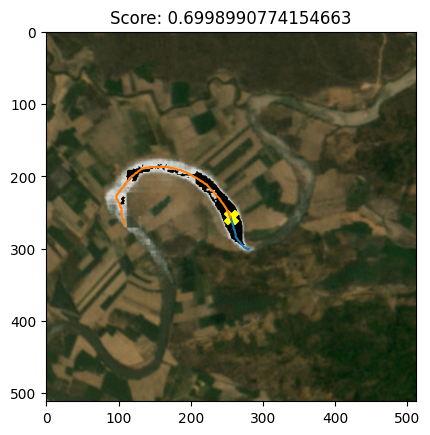

In [28]:
# plt.imshow(skimage.morphology.skeletonize(output['possible']))

src, dst = param.root, param.root + param.patch_size
image = param.image[src[0]:dst[0], src[1]:dst[1]]
logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]
# Plotting
plot = image[:, :, ::-1] * (1- logit[..., None]) / 255 + logit[..., None]
plot = plot * (1 - param.b_mask[src[0]:dst[0], src[1]:dst[1]][..., None])
plt.imshow(plot)
# plt.colorbar()
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", (np.repeat(output['thin'][:, :, None] / output['thin'].max(), 3, axis=-1) * 255).astype(int).astype(np.uint8))
branches = [np.array(branch) for branch in output['branches']]
prompt = output['infer']['prompt'] - param.root
annotation = output['infer']['pts']
a_label = output['infer']['label'][:, None]
color = [0, 0, 1, 0.5] * a_label + [1, 0, 0, 0.5] * (1 - a_label)
plt.title(f"Score: {output['infer']['score']}")
plt.scatter(annotation[:, 0], annotation[:, 1], s=50, c=color, marker='*')
plt.scatter(prompt[1], prompt[0], s=100, c=[1, 1, 0, 1], marker='X')
# pt = output['infer']['prompt']
# plt.scatter(pt[1], pt[0])
for branch in branches:
    plt.plot(branch[:, 1], branch[:, 0])

In [29]:
p = 0.98
score = np.quantile(prob_map, p)
prob_map = sigmoid(output['infer']['logit'])
plt.imshow(prob_map > score)
plt.title(f"{p}-quantile {score}")

NameError: name 'prob_map' is not defined

In [ ]:
param.queue

In [ ]:
dist = param.pos[:, None, :] - param.pos[None, :, :]
loss = np.linalg.norm(dist, axis=2)

In [ ]:
loss

array([[  0.        , 173.56554958, 117.68602296],
       [173.56554958,   0.        ,  81.39410298],
       [117.68602296,  81.39410298,   0.        ]])

In [ ]:
print(param.pos)

[[2619  662]
 [2584  492]
 [2644  547]]


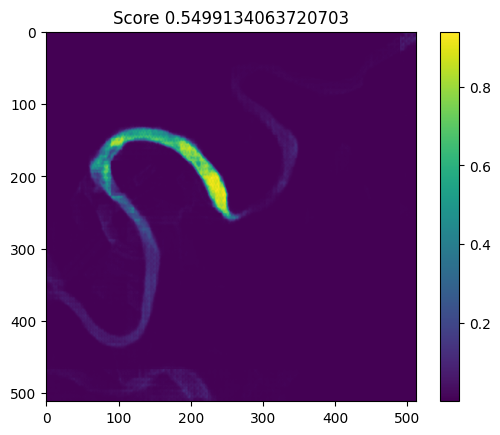

In [ ]:
plt.imshow(logit ** 2)
plt.title(f"Score {output['infer']['score']}")
plt.colorbar()

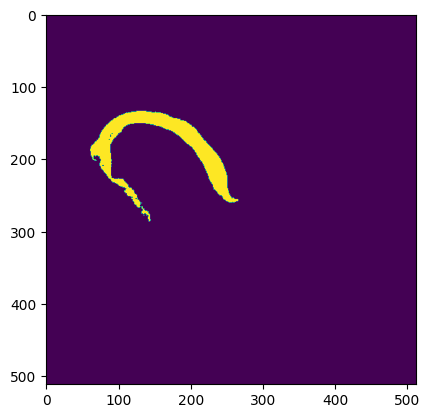

In [ ]:
plt.imshow(logit > 0.458)

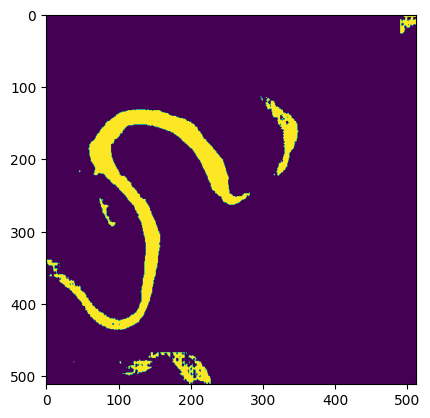

In [ ]:
plt.imshow(logit > param.alpha)

In [ ]:
print(logit.min(), logit.max())

0.002236310515234635 0.9697896418846053


NameError: name 'pt' is not defined

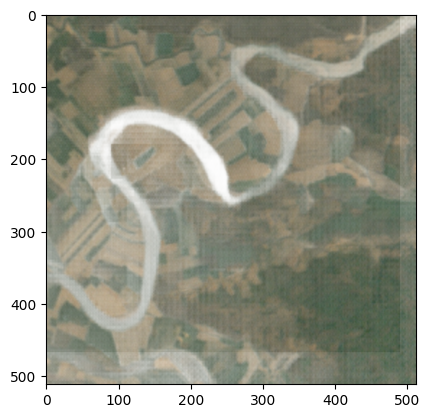

In [ ]:
ret = logit ** 0.3
plt.imshow(image[:, :, ::-1] * (1- ret[..., None]) / 255 + ret[..., None])

plt.scatter(pt[1], pt[0], s=0.5, c=(1, 1, 1))

In [ ]:
output = param.iter()
src, dst = param.root, param.root + param.patch_size
image = param.image[src[0]:dst[0], src[1]:dst[1]]
logit = param.logits[src[0]:dst[0], src[1]:dst[1]] / param.weight[src[0]:dst[0], src[1]:dst[1]]
# Plotting
plot = image[:, :, ::-1] * (1- logit[..., None]) / 255 + logit[..., None]
plot = plot * (1 - param.b_mask[src[0]:dst[0], src[1]:dst[1]][..., None])
plt.imshow(plot)
# plt.colorbar()
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", (np.repeat(output['thin'][:, :, None] / output['thin'].max(), 3, axis=-1) * 255).astype(int).astype(np.uint8))
branches = [np.array(branch) for branch in output['branches']]
pt = output['infer']['prompt'] - param.root
plt.scatter(pt[1], pt[0])
for branch in branches: 
    print(branch.shape[0])
    plt.plot(branch[:, 1], branch[:, 0])

(256, 256) (9,) (9, 2)
[512 512] (512, 512) float32
Score 0.5377235412597656
With 3.0 positives and 6.0 negatives


AttributeError: 'SamInferer' object has no attribute 'mask'

In [ ]:
plt.imshow(mask)
plt.title(f"Score: {score}")

In [ ]:
prob = sigmoid(logit)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
possible = cv2.morphologyEx(np.where(prob > param.alpha, 1, 0).astype(int).astype(np.uint8), cv2.MORPH_CLOSE, kernel, 1)
possible = scipy.ndimage.binary_fill_holes(possible)
possible = getLargestCC(possible).astype(int).astype(np.uint8)
plt.imshow(possible)

In [ ]:
thin, thin_w = morpholgy_thinning(possible, return_weight=True)

In [ ]:
plt.imshow(thin_w * (thin_w < thin_w.max() * 0.75))
plt.title(f"Max:{thin_w.max()} ")
plt.colorbar()

In [ ]:
cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
stable = ((thin_w > 0) & (thin_w < thin_w.max() * 0.75)).astype(int).astype(np.uint8)
closed = cv2.morphologyEx(stable, cv2.MORPH_DILATE, kernel, 1)
cv2.imwrite("/work/hpc/potato/airc/data/viz/closed.jpg", np.repeat(closed[:, :, None], 3, axis=-1) * 255)
plt.imshow(closed)

In [ ]:
skeleton = skimage.morphology.skeletonize(closed)
plt.imshow(skeleton)
main_branch = getLargestCC(skeleton).astype(int).astype(np.uint8)
plt.imshow(main_branch)

In [ ]:
w_map = (main_branch * prob) / score
w_map[mask * main_branch == 1] = 1
cv2.imwrite("/work/hpc/potato/airc/data/viz/output.jpg", (np.repeat(w_map[:, :, None], 3, axis=2) * 255).astype(int).astype(np.uint8))
plt.imshow(w_map)
plt.colorbar()

Logit map is same shape to mask prompt, which is half the size of image input

In [ ]:
# Always start at stable mask
w_pts = np.array(np.where(w_map == 1)).T
print(w_pts.shape)
dist = np.linalg.norm(w_pts - res['pts'][-1] / 2, axis=1)
nn = w_pts[np.argmin(dist)]
print(nn, res['pts'][-1] / 2)

In [ ]:
dfs_res = dfs_tree(w_map.copy(), res['inp_mask'], tuple(nn), alpha=0.01, thresh=0.8)

In [ ]:
path, branches = longest_path_branching(dfs_res['dfs_tree'], tuple(nn))

In [ ]:
path = np.array(path)
branches = [np.array(branch) for branch in branches]

In [ ]:
leaves = np.array(list(dfs_res['leaves']))
cost_map = dfs_res['cost']
cost_map[cost_map > 100] = 0
plt.plot(path[:, 1], path[:, 0])
for branch in branches: 
    plt.plot(branch[:, 1], branch[:, 0])
plt.imshow(cost_map ** 0.3)
plt.scatter(leaves[:, 1], leaves[:, 0], s=0.2)
plt.colorbar()

In [ ]:
accepted_branch = [branches[i] for i in range(len(branches)) if len(branches[i]) > 10]

In [ ]:
accepted_branch

In [ ]:
len(accepted_branch[0])